In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
# path = "data/dogscats/"
path = "data/dogscats/sample/"

In [5]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Basic image recognition

In [6]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=4)

Found 16 images belonging to 2 classes.


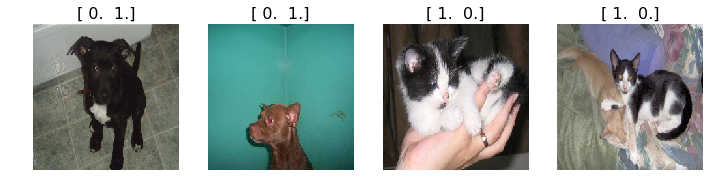

In [7]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [8]:
vgg.predict(imgs, True)

(array([ 0.1152,  0.3969,  0.1044,  0.2421], dtype=float32),
 array([227, 151, 333, 158]),
 [u'kelpie', u'Chihuahua', u'hamster', u'toy_terrier'])

## Fine-tuning for dogs and cats

In [9]:
batch_size = 64
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [ ]:
vgg.finetune(batches)
??Vgg16

In [13]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
16/16 [==============================] - 1s - loss: 0.6615 - acc: 0.7500 - val_loss: 0.3140 - val_acc: 0.8750


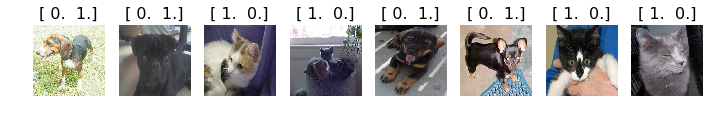

In [17]:
imgs, labels = next(val_batches)
plots(imgs, titles=labels)

In [ ]:
print(imgs)
vgg.predict(imgs)

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

## Imlement the model with Keras

In [20]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [21]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]